In [3]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation

from keras.constraints import maxnorm

In [4]:
pathToImages = '/home/nbellorin/PycharmProjects/procesamientoImagenes/spyderScripts/dataGenerated/resized'

#pathToImages = '/home/nbellorin/Documentos/universidad/TFM/neuronalNetworks/ClasificacionImagenesDeportes/sportimages'

dirname = os.path.join(os.getcwd(), pathToImages)
imgpath = dirname + os.sep 

print(os.getcwd())
print(os.sep)
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

/home/nbellorin/PycharmProjects/procesamientoImagenes/spyderScripts/dataGenerated
/
leyendo imagenes de  /home/nbellorin/PycharmProjects/procesamientoImagenes/spyderScripts/dataGenerated/resized/
/home/nbellorin/PycharmProjects/procesamientoImagenes/spyderScripts/dataGenerated/resized/nodni 1
/home/nbellorin/PycharmProjects/procesamientoImagenes/spyderScripts/dataGenerated/resized/dni 2399
Directorios leidos: 2
Imagenes en cada directorio [2400, 2898]
suma Total de imagenes en subdirs: 5298


In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1
 
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
 
# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  5298
0 nodni
1 dni
Total number of outputs :  2
Output classes :  [0 1]


In [6]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
 
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (4238, 21, 28, 3) (4238,)
Testing data shape :  (1060, 21, 28, 3) (1060,)
Original label: 1
After conversion to one-hot: [0. 1.]
(3390, 21, 28, 3) (848, 21, 28, 3) (3390, 2) (848, 2)


In [ ]:
#UNA SOLA CAPA SIN NORMALIZAR
INIT_LR = 1e-3
epochs = 25
batch_size = 100
 
clf = Sequential()
clf.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
clf.add(LeakyReLU(alpha=0.1))
clf.add(MaxPooling2D((2, 2),padding='same'))
clf.add(Dropout(0.5))
 
clf.add(Flatten())
clf.add(Dense(32, activation='linear'))
clf.add(LeakyReLU(alpha=0.1))
clf.add(Dropout(0.5)) 
clf.add(Dense(nClasses, activation='softmax'))
 
clf.summary()
 
clf.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train_dropout = clf.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
#clf.save("sports_mnist.h5py")

test_eval = clf.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [16]:
#UNA SOLA CAPA NORMALIZANDO -- OPTIMO
INIT_LR = 1e-3
epochs = 100
batch_size = 100
 
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())
 
sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))
 
sport_model.summary()
 
sport_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("myModel_mnist.h5py")


test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 11, 14, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 11, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 4928)             

34/34 [==============================] - 1s 19ms/step - loss: 0.1568 - accuracy: 0.9372 - val_loss: 0.1088 - val_accuracy: 0.9646
Epoch 46/100
34/34 [==============================] - 1s 18ms/step - loss: 0.1462 - accuracy: 0.9437 - val_loss: 0.1141 - val_accuracy: 0.9552
Epoch 47/100
34/34 [==============================] - 1s 18ms/step - loss: 0.1432 - accuracy: 0.9484 - val_loss: 0.1068 - val_accuracy: 0.9611
Epoch 48/100
34/34 [==============================] - 1s 18ms/step - loss: 0.1464 - accuracy: 0.9416 - val_loss: 0.1069 - val_accuracy: 0.9611
Epoch 49/100
34/34 [==============================] - 1s 19ms/step - loss: 0.1505 - accuracy: 0.9437 - val_loss: 0.1054 - val_accuracy: 0.9623
Epoch 50/100
34/34 [==============================] - 1s 18ms/step - loss: 0.1404 - accuracy: 0.9484 - val_loss: 0.1009 - val_accuracy: 0.9670
Epoch 51/100
34/34 [==============================] - 1s 18ms/step - loss: 0.1514 - accuracy: 0.9398 - val_loss: 0.1009 - val_accuracy: 0.9658
Epoch 52/100

INFO:tensorflow:Assets written to: myModel_mnist.h5py/assets


INFO:tensorflow:Assets written to: myModel_mnist.h5py/assets


34/34 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.9717
Test loss: 0.08405577391386032
Test accuracy: 0.9716981053352356


In [18]:
sport_model.save("myModel_mnist.h5py")

INFO:tensorflow:Assets written to: myModel_mnist.h5py/assets


INFO:tensorflow:Assets written to: myModel_mnist.h5py/assets


In [14]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

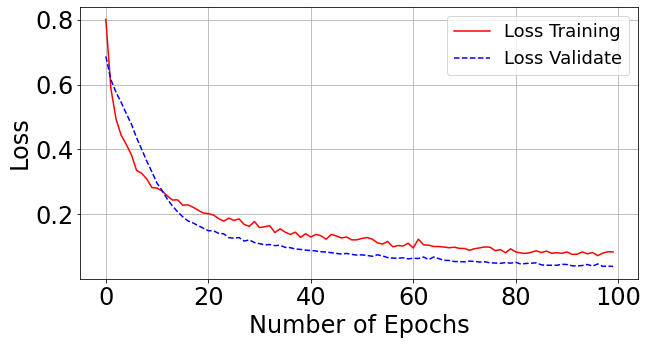

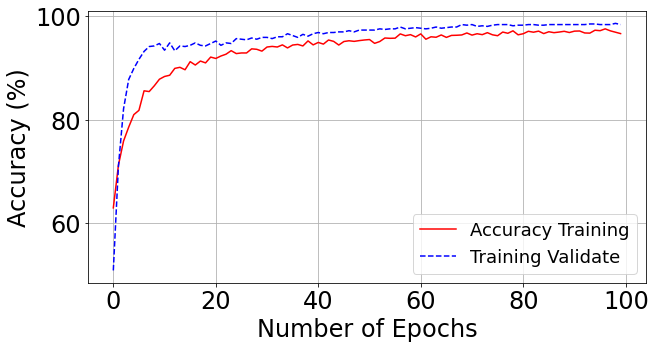

In [15]:
plotTraining(sport_train_dropout,epochs,"loss")
plotTraining(sport_train_dropout,epochs,"accuracy")
plotTraining(sport_train_dropout,epochs,"val_loss")
plotTraining(sport_train_dropout,epochs,"val_accuracy")

In [ ]:
#DOS CAPAS NORMALIZANDO
INIT_LR = 1e-3
epochs = 25
batch_size = 100
 
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())

sport_model = Sequential()
sport_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())
 
sport_model.add(Flatten())
sport_model.add(Dense(32, kernel_constraint=maxnorm(3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))
 
sport_model.summary()
 
sport_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
#sport_model.save("sports_mnist.h5py")

test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [ ]:
#DOS CAPAS NORMALIZANDO
INIT_LR = 1e-3
epochs = 10
batch_size = 100
 
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())

sport_model = Sequential()
sport_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())
 
sport_model.add(Flatten())
sport_model.add(Dense(32, kernel_constraint=maxnorm(3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))
 
sport_model.summary()
 
sport_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
#sport_model.save("sports_mnist.h5py")

In [ ]:
#MUCHAS CAPAS NORMALIZANDO
INIT_LR = 1e-3
epochs = 25
batch_size = 100
 
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())

sport_model = Sequential()
sport_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())

sport_model = Sequential()
sport_model.add(Conv2D(128, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())

sport_model = Sequential()
sport_model.add(Conv2D(256, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
sport_model.add(BatchNormalization())


sport_model.add(Flatten())
sport_model.add(Dense(64, kernel_constraint=maxnorm(3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))
 
sport_model.summary()
 
sport_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
#sport_model.save("sports_mnist.h5py")

In [ ]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [ ]:
#========> MODELO 2
INIT_LR = 1e-3
epochs = 10
batch_size = 100
 
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(Activation('relu'))
sport_model.add(Dropout(0.2))
sport_model.add(BatchNormalization())

sport_model.add(Conv2D(64, (3, 3), padding='same'))
sport_model.add(Activation('relu'))
sport_model.add(MaxPooling2D(pool_size=(2, 2)))
sport_model.add(Dropout(0.2))
sport_model.add(BatchNormalization())



sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))

sport_model.add(Dense(nClasses, activation='softmax'))
 
sport_model.summary()
 
sport_model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
#sport_model.save("sports_mnist.h5py")

In [ ]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

1/1 [==============================] - 0s 95ms/step
dni


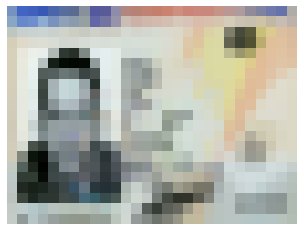

In [24]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
import cv2

names = ['nodni','dni']

modelt = load_model("myModel_mnist.h5py")
#modelt = custom_vgg_model

imaget_path = "prueba/prueba.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (28, 21), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()